In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ----------------------------- ตั้งค่า -----------------------------
DATA_DIR = r"C:\\Users\\ADMIN\\Desktop\\Sleep recording\\dataeeg_custom_10s"
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"ใช้ device: {DEVICE}")

CHUNK_SIZE = 2560  # 256 Hz * 10 วินาที
NUM_CLASSES = 5

ใช้ device: cpu


In [3]:
# ----------------------------- TinySleepNet Model (standalone) -----------------------------
class TinySleepNet(nn.Module):
    def __init__(self, num_classes=5, chunk_size=2660, dropout=0.5):
        super(TinySleepNet, self).__init__()
        
        # Branch 1: Representation learning (short-term features)
        self.branch1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=50, stride=6, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Dropout(dropout),
            nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.Dropout(dropout)
        )
        
        # Branch 2: Sequence residual learning (long-term dependencies) - Simplified for efficiency
        self.branch2 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=400, stride=50, padding=0),  # Larger kernel for longer context
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.Dropout(dropout)
        )
        
        # Calculate output size after conv/pool (approximate for chunk_size=2660)
        self.fc1_size = 128 * 8  # Adjust based on your actual output shape after testing
        
        # LSTM for sequence modeling
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, bidirectional=True, batch_first=True)
        
        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(256, 128),  # 128*2 because bidirectional LSTM
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x shape: (batch, 1, chunk_size) e.g. (32, 1, 2660)
        
        # Branch 1
        b1 = self.branch1(x)
        b1 = b1.permute(0, 2, 1)  # (batch, seq_len, features)
        
        # Branch 2 (optional fusion, but here we use branch1 mainly for simplicity)
        # b2 = self.branch2(x)
        # b2 = b2.permute(0, 2, 1)
        # fused = torch.cat([b1, b2], dim=2)  # If want fusion
        
        # LSTM
        lstm_out, (h, c) = self.lstm(b1)
        lstm_out = lstm_out[:, -1, :]  # Take last timestep
        
        # Classifier
        out = self.fc(lstm_out)
        return out

In [4]:
# ----------------------------- Dataset -----------------------------
class SleepDataset(Dataset):
    def __init__(self, file_list):
        self.X = []
        self.y = []
        for file in file_list:
            data = np.load(file)
            self.X.append(data['X'])
            self.y.append(data['y'])
        self.X = np.concatenate(self.X, axis=0)
        self.y = np.concatenate(self.y, axis=0)
        print(f"โหลดข้อมูล: {len(self.X)} epochs")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()  # (2660, 1)
        x = x.permute(1, 0)  # (1, 2660)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [8]:
# ----------------------------- โหลดข้อมูล -----------------------------
all_npz = glob.glob(os.path.join(DATA_DIR, "*.npz"))
if not all_npz:
    raise FileNotFoundError(f"ไม่พบ .npz ใน {DATA_DIR}")

train_files, test_files = train_test_split(all_npz, test_size=0.25, random_state=42)

train_dataset = SleepDataset(train_files)
test_dataset = SleepDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

โหลดข้อมูล: 30682 epochs
โหลดข้อมูล: 11927 epochs


In [9]:
# ----------------------------- Train -----------------------------
model = TinySleepNet(num_classes=NUM_CLASSES, chunk_size=CHUNK_SIZE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nเริ่ม train...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {running_loss / len(train_loader):.4f}")


เริ่ม train...
Epoch 1/30 - Loss: 1.2282
Epoch 2/30 - Loss: 1.0299
Epoch 3/30 - Loss: 0.9822
Epoch 4/30 - Loss: 0.9483
Epoch 5/30 - Loss: 0.9234
Epoch 6/30 - Loss: 0.9064
Epoch 7/30 - Loss: 0.8893
Epoch 8/30 - Loss: 0.8745
Epoch 9/30 - Loss: 0.8703
Epoch 10/30 - Loss: 0.8599
Epoch 11/30 - Loss: 0.8477
Epoch 12/30 - Loss: 0.8385
Epoch 13/30 - Loss: 0.8350
Epoch 14/30 - Loss: 0.8256
Epoch 15/30 - Loss: 0.8269
Epoch 16/30 - Loss: 0.8154
Epoch 17/30 - Loss: 0.8103
Epoch 18/30 - Loss: 0.8092
Epoch 19/30 - Loss: 0.8034
Epoch 20/30 - Loss: 0.7949
Epoch 21/30 - Loss: 0.7926
Epoch 22/30 - Loss: 0.7913
Epoch 23/30 - Loss: 0.7913
Epoch 24/30 - Loss: 0.7906
Epoch 25/30 - Loss: 0.7846
Epoch 26/30 - Loss: 0.7798
Epoch 27/30 - Loss: 0.7818
Epoch 28/30 - Loss: 0.7730
Epoch 29/30 - Loss: 0.7673
Epoch 30/30 - Loss: 0.7662



Accuracy: 53.89%
Kappa: 0.4025
              precision    recall  f1-score   support

          N1       0.25      0.05      0.08      1860
          N2       0.62      0.50      0.56      4476
          N3       0.59      0.60      0.59      1920
         REM       0.43      0.58      0.50      1449
        Wake       0.52      0.94      0.67      2222

    accuracy                           0.54     11927
   macro avg       0.48      0.53      0.48     11927
weighted avg       0.52      0.54      0.50     11927



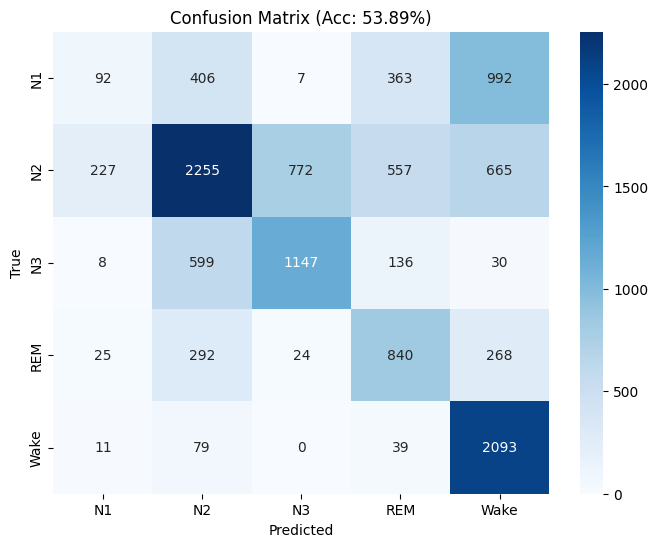

In [10]:
# ----------------------------- Evaluate -----------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print(f"\nAccuracy: {acc*100:.2f}%")
print(f"Kappa: {kappa:.4f}")
print(classification_report(y_true, y_pred, target_names=['N1', 'N2', 'N3', 'REM', 'Wake']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N1', 'N2', 'N3', 'REM', 'Wake'],
            yticklabels=['N1', 'N2', 'N3', 'REM', 'Wake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Acc: {acc*100:.2f}%)')
plt.show()